# Topic Modeling using Scikit-learn and Gensim
Suppose we have a large collection of documents and we are interested in indentifying the underlying themes in this corpus. Topic modeling offeres a way to achieve this in an unsupervised manner. Here, I used **Latent Dirichlet Allocation (LDA)**, a popular topic modeling technique, to explore a corpus of grants awarded by the National Science Foundation (NSF).

## Download the NSF award abstracts using lxml.etree
I downloaded NSF award abstracts from https://www.nsf.gov/awardsearch/download.jsp. This webpage contains links to the zip files containing all the NSF awards made in each fiscal year scince 1959. I retrieved the links and saved the zip files containing awards made from 1981 to the present. Total size of all the zip files is about 600 MB.

In [1]:
from lxml import etree
from io import BytesIO
import re

try:
    # For Python 3.0 and later
    from urllib.request import urlopen   
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen

In [2]:
parser = etree.HTMLParser()
html = urlopen('https://www.nsf.gov/awardsearch/download.jsp')
tree = etree.parse(BytesIO(html.read()), parser=parser)

In [3]:
base_url = 'https://www.nsf.gov/awardsearch/'

year_subset = [1981+i for i in range(0,37,1)]

for url in tree.xpath("//div[@class='downloadcontent']//a/@href"):
    try:
        year = int(re.findall(r'\b\d+\b', url)[0])
        if year in year_subset:
            #print (year)
            url = base_url + url
            f = urlopen(url)
            with open (str(year) + ".zip", 'wb') as data:
                data.write(f.read())
    except:
        pass

## Retrieve the relevant information from xml files using lxml.etree.
Each zip archive contains several xml files and each xml file contains one award. The schema for these XML files is availabe at https://www.nsf.gov/awardsearch/resources/Award.xsd.

Here, I have only considered the projects funded by the **Division of Materials Research**. There are total 371,948 awards out of which 14,602 awards were made by the Division of Materials Research. I scraped the relevant information for each award from the xml files and saved the data in a dictionary *awards_dict*.

In [1]:
import zipfile
import os, fnmatch
import pickle
import collections

In [5]:
parser = etree.HTMLParser()

def extract_award_info(xml, division_tag):
    try:
        #tree = etree.fromstring(xml, parser=parser)
        tree = etree.parse(BytesIO(xml), parser=parser)
    except:
        return
    
    aid = tree.find('.//awardid').text
    
    try:
        div = tree.find('.//division//longname').text
        if division_tag.lower() not in div.lower():
            return
    except:
        return
    
    awards_dict[aid] = {}
    awards_dict[aid]['effectivedate'] = tree.find('.//awardeffectivedate').text
    awards_dict[aid]['expirationdate'] = tree.find('.//awardexpirationdate').text
    awards_dict[aid]['directorate'] = tree.find('.//directorate//longname').text
    awards_dict[aid]['division'] = tree.find('.//division//longname').text

    try:
        awards_dict[aid]['title'] = tree.find('.//awardtitle').text
    except:
        awards_dict[aid]['title'] = re.findall("<(?i)awardtitle>(.*?)"
                                                  "</(?i)awardtitle>", 
                                               xml.decode("latin1"))[0]
    try:
        awards_dict[aid]['abstract'] = tree.find('.//abstractnarration').text   
    except:
        # got 'utf-8' errors in some cases. Use regex for those cases.
        awards_dict[aid]['abstract'] = re.findall("<(?i)abstractnarration>"
                                                  "(.*?)</(?i)abstractnarration>", 
                                                  xml.decode("latin1"))[0]
        # (?i) in regex allows for case insensitive matching. 
        # double-quotes allow for splitting long regex patterns over multiple lines.
    #print awards_dict

In [6]:
division_tag = 'Materials Research'
dirname = './nsf_zip_archives'

awards_dict = collections.OrderedDict()
nawards = 0
year_list = sorted([y[:-4] for y in fnmatch.filter(os.listdir(dirname), '*.zip')])
for y in year_list:
    zipf = y+'.zip'
    zipf = os.path.join(dirname, zipf)
    archive = zipfile.ZipFile(zipf)
    
    for name in archive.namelist():
        #if (name not in '0923604.xml') and (name not in '0923577.xml'):
        #    continue
        #print (name)
        data = archive.read(name)
        extract_award_info(data, division_tag)
        nawards += 1
    archive.close()
    
print ('{:d} {:s} related awards out of total {:d} awards'.format(len(awards_dict), division_tag, nawards))

/home/nkharche/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:38: DeprecationWarning: Flags not at the start of the expression <(?i)abstractnarrati (truncated)
/home/nkharche/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: DeprecationWarning: Flags not at the start of the expression <(?i)awardtitle>(.*? (truncated)


14602 Materials Research related awards out of total 371948 awards


In [7]:
with open('awards_dict_materials.pkl', 'wb') as handle:
    pickle.dump(awards_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('awards_dict_dmr.pkl', 'rb') as handle:
#    awards_dict = pickle.load(handle)    

## Text cleanup
Now we clean up the text of all the award abstracts, keeping only the letters and removing the stopwords. The cleaned data are saved in a dictionary *awards_dict_clean*.

In [8]:
from spacy.en import English
from spacy.en import STOP_WORDS
nlp = English()

In [9]:
def text_cleanup(text):
    # convert to lowercase
    text = text.lower() 
    # Extract only characters
    letters_only = re.sub("[^a-zA-Z]"," ",text)
    words = letters_only.split()
    # Remove stop-words
    useful_words = ' '.join([x for x in words if not x in STOP_WORDS])

    return useful_words

In [10]:
awards_dict_clean = collections.OrderedDict()
for k,v in awards_dict.items():
    abstract = v['abstract']
    if not abstract:
        continue # Abstract text not available
    awards_dict_clean[k] = {}
    awards_dict_clean[k]['title'] = v['title']
    awards_dict_clean[k]['effectivedate'] = v['effectivedate']
    awards_dict_clean[k]['abstract'] = text_cleanup(abstract) 

In [11]:
print (len(awards_dict))
print (len(awards_dict) - len(awards_dict_clean))

14602
1848


In [12]:
with open('awards_dict_materials_clean.pkl', 'wb') as handle:
    pickle.dump(awards_dict_clean, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open('awards_dict_materials_clean.pkl', 'rb') as handle:
#    awards_dict_clean = pickle.load(handle)    

## Topic detection
Now we are ready to do Topic Modeling.

In [2]:
from time import time
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from gensim import matutils, corpora
from gensim.models import LdaModel, LdaMulticore
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

### Bag-of-words representation
First step is to convert the text into a bag-of-words representation, I used sklearn's CountVectorizer for this purpose. 
* In addition to monograms, I also included bigrams and trigrams to allow for features such as for example "phase transition", "transition metal oxide", "monte carlo simulation", etc.
* I used *max_df*=0.95 to discard common words appearing in more than 95% of the documents and *min_df*=0.01 to discard rare words appearing in less than 1% documents.
* This creats a vocabulary of 2,821 features.

In [16]:
abstacts_list = [aw['abstract'] for aw in awards_dict_clean.values()]
add_stop_words = {'lt', 'gt', 'br', 'abstract', 'allow', 'analysis', 'approach', 'award', 'base', 'broad', 'department', 
                  'description', 'develop', 'division', 'focus', 'foundation', 'fundwork', 'goal', 'high', 'impact', 
                  'important', 'improve', 'include', 'lab', 'laboratory', 'large', 'method', 'national', 'need', 'new', 
                  'office', 'pi', 'principal investigator', 'problem', 'program', 'project', 'proposal', 'provide', 'purpose', 
                  'require', 'research', 'result', 'science', 'student', 'study', 'support', 'technical', 'understand', 
                  'university', 'use', 'material', 'materials', 'properties'}

#n_features = 50000

print ('Calculating tf')
t0 = time()
tf_vectorizer = CountVectorizer(#max_features=n_features, 
                                ngram_range=(1,3), 
                                max_df=0.95,
                                min_df=0.01,
                                stop_words=STOP_WORDS.union(add_stop_words))
tf = tf_vectorizer.fit_transform(abstacts_list)
tf_feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

Calculating tf
done in 23.197s.


In [17]:
vocab = tf_vectorizer.get_feature_names()
id2word = dict([(i, s) for i, s in enumerate(vocab)])

In [18]:
dictionary = corpora.Dictionary([list(id2word.values())])
print (len(dictionary))

#for (k1,v1),(k2,v2) in zip(id2word.items(), dictionary.token2id.items()):
#    if not ((k1,v1)==(v2,k2)):
#        print ('ERROR')

2821


In [19]:
post_proc_bows = tf_vectorizer.inverse_transform(tf)
corpus = [dictionary.doc2bow(list(text)) for text in post_proc_bows]

### Model generation
I ran LDA with 25 topics. Most of the topics found in this run make sense, so I didn't refine the model further. Ideally, we would choose the number of topics by running LDA with varying number of topics and/or seeding specific topics based on some domain knowledge.

In [20]:
""" Fit LDA from a scipy CSR matrix (X). """
num_topics = 25
print ('fitting lda...')
t0 = time()
lda = LdaMulticore(matutils.Sparse2Corpus(tf, documents_columns=False), 
                   id2word=id2word, num_topics=num_topics,
                   chunksize=2000, passes=10, random_state=1,
                   #alpha='auto'
                  )
print("done in %0.3fs." % (time() - t0))

fitting lda...
done in 278.231s.


In [5]:
with open('gensim_lda_'+str(num_topics)+'_topics.pkl', 'wb') as handle:
    pickle.dump((lda,tf,dictionary), handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#data_file = 'gensim_lda_'+str(num_topics)+'_topics.pkl'
#with open(data_file, 'rb') as handle:
#    lda,tf,dictionary = pickle.load(handle)

###  Analysis using LDAvis
Output of LDA consists of a document-topic distribution (a matrix of size $num\_documents\ \times\ num\_topics$), which is usually denote by $\theta$ and a topic-word distribution (a matrix of size $num\_topics \times num\_words$), which is usually denoted by $\phi$. Interpreting the meaning of the topics from these probability distributions can be a difficult task.

Fortunately, [**LDAvis**](https://github.com/bmabey/pyLDAvis) package provides an excellent [D3](https://d3js.org/)-based interactive visualization of the output of LDA. Check out [this](https://www.youtube.com/watch?v=tGxW2BzC_DU&index=4&list=PLykRMO7ZuHwP5cWnbEmP_mUIVgzd5DZgH) YouTube video demonstration of LDAvis. We can decrease the relevance metric $\lambda$ to highlight the terms that are more specific to a selected topic. I used $\lambda\ = \ 0.4$. You can explore the model yourself by selecting different topics in the left panel and selecting different terms and adjusting $\lambda$ in the right panel.

In [6]:
vis_data = gensimvis.prepare(lda, tf.T, dictionary, mds='tsne', sort_topics=False)
pyLDAvis.display(vis_data)

Based on the relevant terms in each topic found by the LDA model, I labelled the topics as follows:

<table>
  <tr>
    <td style="font-weight:bold">Topic ID</td>
    <td style="font-weight:bold">Topic label</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Spectroscopic methods for materials characterization</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Condensed matter physics</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Low temperature physics</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Self-assembly and biological materials</td>
  </tr>
  <tr>
    <td>5</td>
    <td>Education and outreach to high schools and undergraduate students</td>
  </tr>
  <tr>
    <td>6</td>
    <td>Energy conversion (e.g. solar) and storage (e.g. batteries)</td>
  </tr>
  <tr>
    <td>7</td>
    <td>Optical properties</td>
  </tr>
  <tr>
    <td>8</td>
    <td>Mechanical properties</td>
  </tr>
  <tr>
    <td>9</td>
    <td style="color:gray">Seems to be a mixture of several topics</td>
  </tr>
  <tr>
    <td>10</td>
    <td>Research Experience for Undergraduates (REU) programs and American recovery and reinvestment act (2009)</td>
  </tr>
  <tr>
    <td>11</td>
    <td>Microscopy techniques</td>
  </tr>
  <tr>
    <td>12</td>
    <td style="color:gray">Seems to be a mixture of several topics</td>
  </tr>
  <tr>
    <td>13</td>
    <td>Conferences and workshops</td>
  </tr>
  <tr>
    <td>14</td>
    <td>Statistical mechanics</td>
  </tr>
  <tr>
    <td>15</td>
    <td>Computational methods</td>
  </tr>
  <tr>
    <td>16</td>
    <td>Magnetic materials</td>
  </tr>
  <tr>
    <td>17</td>
    <td>Polymers</td>
  </tr>
  <tr>
    <td>18</td>
    <td style="color:gray">Seems to be a mixture of several topics</td>
  </tr>
  <tr>
    <td>19</td>
    <td>Superconductors</td>
  </tr>
  <tr>
    <td>20</td>
    <td>Materials fabrication methods</td>
  </tr>
  <tr>
    <td>21</td>
    <td>Technological relevance</td>
  </tr>
  <tr>
    <td>22</td>
    <td>Quantum phenomena</td>
  </tr>
  <tr>
    <td>23</td>
    <td>Thin films: growth and applications</td>
  </tr>
  <tr>
    <td>24</td>
    <td>Molecular dynamics simulations</td>
  </tr>
  <tr>
    <td>25</td>
    <td>Liquid crystals</td>
  </tr>
 </table>

### Temporal trends
Now we can quantify temporal trends of different topics by counting the number of documents that contain a given topic. This can be achieved using the document-topic matrix $\theta$. I used threshold topic proportion of 33% i.e. document $d$ contains topic $k$ if $\theta_{dk}>0.33$. I saved yearly document counts for each topic in a **Pandas** dataframe.

In [23]:
thetas, _ = lda.inference(corpus)
thetas /= thetas.sum(axis=1)[:, None]

In [24]:
threshold = 0.33
thts = np.copy(thetas)
thts[thts < threshold] = 0
thts[thts >= threshold] = 1
thts = thts.astype(int)

In [25]:
award_year = [int(aw['effectivedate'].split('/')[2]) for aw in awards_dict_clean.values()]
topics = ['T'+str(i) for i in np.linspace(1,len(thts[0]),num_topics, dtype='int')]

In [26]:
df = pd.DataFrame(thts, columns=topics)
df['year'] = award_year
df = df.groupby(by=['year']).sum()
df.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25
year,,,,,,,,,,,,,,,,,,,,,
1985,1,0,2,0,0,0,0,1,0,0,...,0,2,1,2,0,0,0,0,0,1
1986,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
1987,8,10,12,0,6,1,3,14,0,0,...,2,18,17,19,9,0,1,2,10,13
1988,19,14,9,0,5,2,3,19,1,3,...,3,33,37,34,13,2,4,2,17,18
1989,14,27,12,0,0,0,6,23,2,10,...,1,21,35,38,13,0,5,6,11,14


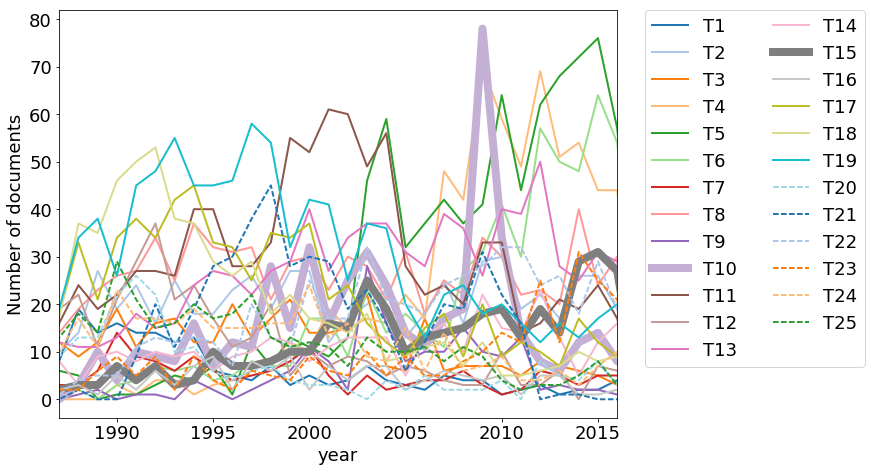

In [27]:
catgory20_pallet = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', 
                    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', 
                    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', 
                    '#17becf', '#9edae5']

plt.figure(figsize=(10,7.5)) 
for i,col in enumerate(df):
    if (i+1)//20==0:
        if i+1 in [10,15]:
            plt.plot(df.index.values, df[col].values, color = catgory20_pallet[i], lw=8, label=df[col].name)
        else:
            plt.plot(df.index.values, df[col].values, color = catgory20_pallet[i], lw=2, label=df[col].name)
    else:
        plt.plot(df.index.values, df[col].values, color = catgory20_pallet[i%20], lw=2, label=df[col].name, linestyle='--')

plt.xlim(1987, 2016)
plt.xlabel('year', fontsize=18)
plt.ylabel('Number of documents', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0., fontsize=18)

I was particularly interested in funding trends in **Computational Materials Science**, the area of my PhD and Postdoctoral research. As it can be seen from the keywords in the above LDAvis visulatization, topic 15 identified by our LDA model is about Computational Materials Science.  The corresponsing trend is shown by thick gray line (T15) in the above figure. We find that the funding in this area is increasing over the years. 

Another interesting trend is seen in topic 10. There is a large spike in the year 2009. This topic contains a mixture of keywords related to Research Experience for Undergraduates (REU) programs and [American recovery and reinvestment act of 2009](https://en.wikipedia.org/wiki/American_Recovery_and_Reinvestment_Act_of_2009). This act was signed into law by President Barak Obama in February 2009 in response to the finantial crisis of 2007-2009.

Further analysis of this topic model would reveal several more insights. However, I would stop here for now. Overall, this was a fun exercise!